In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer #Using porterstemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer   
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.models import Model
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score

In [2]:
#Importing the data
reviews = pd.read_csv('IMDB.csv')

In [3]:
#Let's visualise the rate of sentiments(positive and negative)
sentiment_counts = reviews['sentiment'].value_counts()

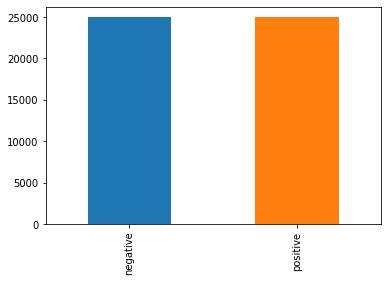

In [4]:
sentiment_counts.plot(kind='bar',color=['C0','C1'])

In [5]:
# lem = WordNetLemmatizer()
# def word_cleanup(text):
#     reviews = re.sub('\[.*?\]', '', text) # remove square brackets
#     reviews = re.sub(r'[^\w\s]','',reviews) # remove punctuation
#     reviews = re.sub('\w*\d\w*', '', reviews) # remove words containing numbers
#     reviews = re.sub(r'http\S+', '', reviews) #Removes links
#     reviews = re.sub('\n', '', reviews)
#     reviews = re.sub('<.*?>','',reviews)
#     reviews = nltk.word_tokenize(reviews) #Splitting all the sentences into individual words
#     reviews = [word.lower() for word in reviews] #lowering all the alphabets
#     reviews = [lem.lemmatize(word) for word in reviews if not word in set(stopwords.words('english'))]
#     reviews = ' '.join(reviews)
#     return reviews

In [6]:
# reviews['review'] = reviews['review'].apply(word_cleanup)

In [7]:
# reviews.to_csv('cleanedreviews.csv')

In [8]:
data = pd.read_csv('cleanedreviews.csv')

In [9]:
#Removing the html br tag
data['review'] = data['review'].str.replace('br','')

In [10]:
#Let's use wordclouds to check the most number of words that occured
def word_cloud(string):
    wordcloud = WordCloud(
    width = 500,
    height = 500,
    background_color = 'white').generate(str(string))
    fig = plt.figure(
        figsize = (5, 10),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [11]:
positive_reviews = data[data['sentiment']=='positive']
negative_reviews = data[data['sentiment']=='negative']

In [12]:
positive_reviews_only = positive_reviews['review']
negative_reviews_only = negative_reviews['review']

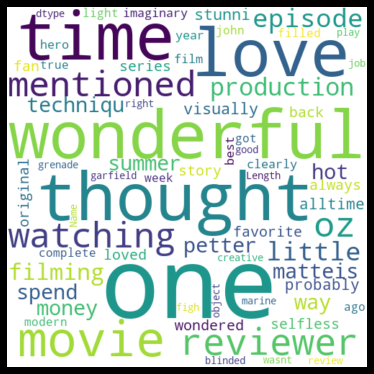

In [13]:
word_cloud(positive_reviews_only)

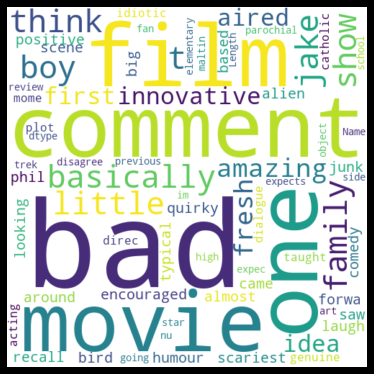

In [14]:
word_cloud(negative_reviews_only)

In [15]:
#Let's check the most occured word in both positive and negative reviews
top_ten_positive_words = Counter(''.join(positive_reviews_only).split()).most_common(10)
top_ten_negative_words = Counter(''.join(negative_reviews_only).split()).most_common(10)

In [16]:
top_ten_positive_words

[('film', 47283),
 ('movie', 41919),
 ('one', 26561),
 ('like', 17367),
 ('time', 15188),
 ('good', 14361),
 ('story', 13682),
 ('character', 13674),
 ('great', 12546),
 ('see', 12288)]

In [17]:
top_ten_negative_words

[('movie', 54443),
 ('film', 41462),
 ('one', 25361),
 ('like', 22074),
 ('even', 15014),
 ('good', 14172),
 ('bad', 14078),
 ('time', 14036),
 ('character', 14000),
 ('would', 13543)]

In [18]:
#Zipping the files to plot the graph
poslabels,posnumbers = zip(*top_ten_positive_words)
neglabels,negnumbers = zip(*top_ten_negative_words)

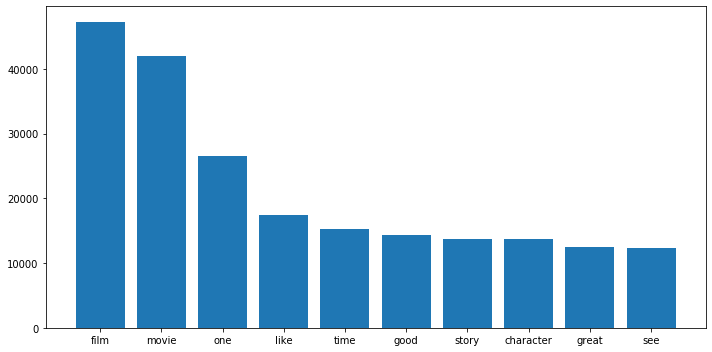

In [19]:
#Plotting the most occured files in the graphs
#Positive reviews
plt.figure(figsize=(10,5))
x_axis = np.arange(len(poslabels)) 
plt.bar(x_axis, posnumbers,width=0.8, align='center')
plt.xticks(x_axis, poslabels)
plt.tight_layout()
plt.show()

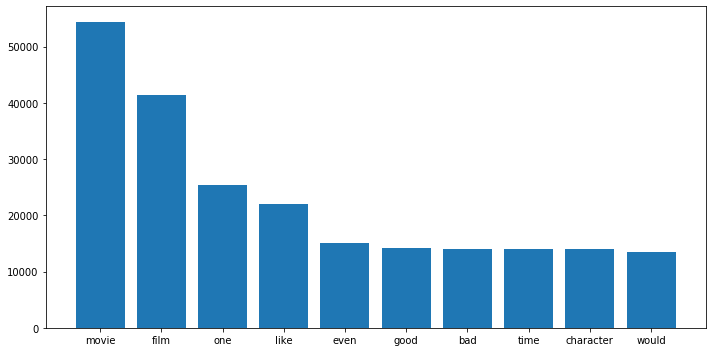

In [20]:
#Negative reviews
plt.figure(figsize=(10,5))
x_axis = np.arange(len(neglabels)) 
plt.bar(x_axis, negnumbers,width=0.8, align='center')
plt.xticks(x_axis, neglabels)
plt.tight_layout()
plt.show()

In [21]:
#Testing various grams for the classification
data.head()

,Unnamed: 0,review,sentiment
0,0,one reviewer mentioned watching oz episode you...,positive
1,1,wonderful little production filming techniqu...,positive
2,2,thought wonderful way spend time hot summer we...,positive
3,3,basically there family little boy jake think t...,negative
4,4,petter matteis love time money visually stunni...,positive


In [22]:
data = data.dropna()

In [23]:
words = ' '.join(data['review'])

In [24]:
words = word_tokenize(words)

## Using different number of grams

### Let's use bigrams

In [25]:
bi_gram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

In [26]:
tri_gram = (pd.Series(nltk.ngrams(words,3)).value_counts())[:20]

Text(0.5, 0, 'No of Occurances')

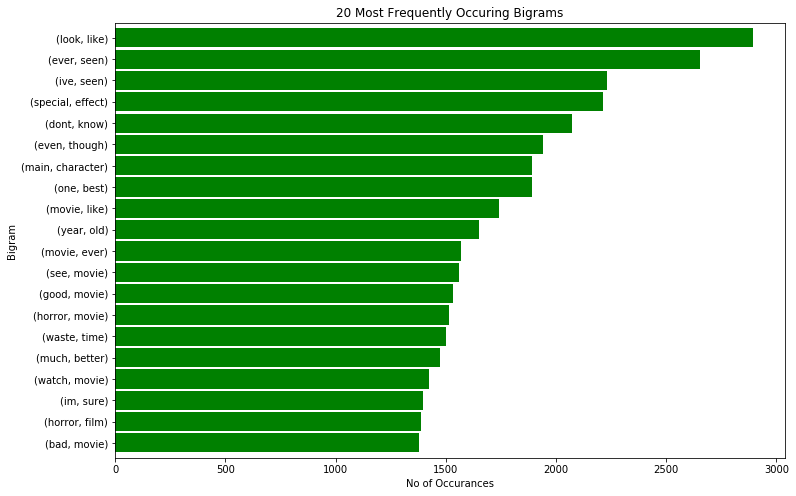

In [27]:
#Visualising the n grams using bar plot
#bigrams
bi_gram.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('No of Occurances')

Text(0.5, 0, 'No of Occurances')

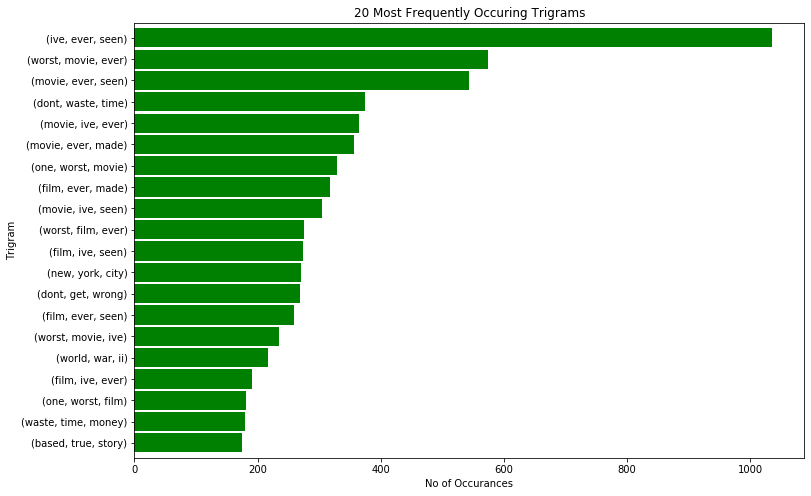

In [28]:
#Visualising the n grams using bar plot
#trigrams
tri_gram.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('No of Occurances')

### Using convolution neural network for nlp


In [29]:
data.head()

,Unnamed: 0,review,sentiment
0,0,one reviewer mentioned watching oz episode you...,positive
1,1,wonderful little production filming techniqu...,positive
2,2,thought wonderful way spend time hot summer we...,positive
3,3,basically there family little boy jake think t...,negative
4,4,petter matteis love time money visually stunni...,positive


In [30]:
X = data['review'].values
Y = data['sentiment'].values

In [31]:
labelEncoder_y = LabelEncoder()
Y = labelEncoder_y.fit_transform(Y)
Y = to_categorical(Y, dtype ="uint8") 

In [32]:
train_data, test_data = train_test_split(data, test_size=0.10, random_state=42)

In [33]:
#Splitting the data into training and testing set
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.25,random_state = 42)

In [34]:
all_training_words = [i.split() for i in train_data['review']]
all_training_wordings = []
for i in range(len(all_training_words)):
    for j in range(len(all_training_words[i])):
        all_training_wordings.append(all_training_words[i][j])
training_vocab = sorted(list(set(all_training_wordings)))

In [35]:
all_testing_words = [i.split() for i in test_data['review']]
all_testing_wordings = []
for i in range(len(all_testing_words)):
    for j in range(len(all_testing_words[i])):
        all_testing_wordings.append(all_testing_words[i][j])
testing_vocab = sorted(list(set(all_testing_wordings)))

In [36]:
tokenizer_train = Tokenizer(num_words = len(training_vocab))
tokenizer_test = Tokenizer(num_words = len(testing_vocab))

In [37]:
tokenizer_train.fit_on_texts(X_train)
tokenizer_test.fit_on_texts(X_test)

In [38]:
X_train = tokenizer_train.texts_to_sequences(X_train)
X_test = tokenizer_test.texts_to_sequences(X_test)

In [39]:
train_vocabulary_size = len(tokenizer_train.word_index)+1
test_vocabulary_size = len(tokenizer_test.word_index)+1

In [40]:
MAX_SEQUENCE_LENGTH = 100

In [41]:
X_train = pad_sequences(X_train, padding = 'post',maxlen = MAX_SEQUENCE_LENGTH)
X_test =  pad_sequences(X_test,padding = 'post',maxlen = MAX_SEQUENCE_LENGTH)

### Using word2vec model to create the embeddings

- A pretrained word2vec model is a model that contains words associated with its word vectors. The pretrained google word2vec model was trained on google news data(about 100 billion words);it contains 3 million words and phrases and the embedding dimension of it is 300

In [42]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

In [43]:
word2vec = KeyedVectors.load_word2vec_format('/Users/shikharghimire/Desktop/machine learning/Natural Language processing/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [44]:
embedding_dim = 300

In [45]:
train_embedding_weights = np.zeros((train_vocabulary_size,embedding_dim))

In [46]:
train_word_index = tokenizer_train.word_index
test_word_index = tokenizer_test.word_index

In [47]:
for train_word,train_index in train_word_index.items():
    train_embedding_weights[train_index,:] = word2vec[train_word] if train_word in word2vec else np.random.rand(embedding_dim)

### Defining the Convolutional Neural Network

In [48]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    convs = []
    filter_sizes = [2,3,4,5,6]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
    l_merge = concatenate(convs, axis=1)
    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [49]:
label_names = ['positive','negative']
model = ConvNet(train_embedding_weights, 
                MAX_SEQUENCE_LENGTH, 
                len(train_word_index)+1, 
                embedding_dim, 
                len(list(label_names)))

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     38682300    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 200)      120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 98, 200)      180200      embedding_1[0][0]                
____________________

In [50]:
num_epochs = 5
batch_size = 32

In [51]:
training = model.fit(X_train, Y_train, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 33750 samples, validate on 3750 samples
Epoch 1/5
33750/33750 [==============================] - 189s 6ms/step - loss: 0.4304 - acc: 0.7953 - val_loss: 0.3139 - val_acc: 0.8601
Epoch 2/5
33750/33750 [==============================] - 186s 6ms/step - loss: 0.2916 - acc: 0.8819 - val_loss: 0.3361 - val_acc: 0.8524
Epoch 3/5
33750/33750 [==============================] - 186s 6ms/step - loss: 0.1986 - acc: 0.9248 - val_loss: 0.3069 - val_acc: 0.8744
Epoch 4/5
33750/33750 [==============================] - 187s 6ms/step - loss: 0.1018 - acc: 0.9650 - val_loss: 0.3416 - val_acc: 0.8727
Epoch 5/5
33750/33750 [==============================] - 187s 6ms/step - loss: 0.0559 - acc: 0.9804 - val_loss: 0.4791 - val_acc: 0.8648


In [52]:
predictions = model.predict(X_test,batch_size,verbose = 1)

12500/12500 [==============================] - 23s 2ms/step


In [53]:
labels = [1,0]

In [54]:
prediction_labels = []
for i in predictions:
    prediction_labels.append(labels[np.argmax(i)])

In [55]:
Y_test = np.argmax(Y_test, axis=1)

In [67]:
#Let's measure precision and recall in the test data
average_precision = average_precision_score(Y_test, prediction_labels)

In [69]:
average_precision #The precision is quite low. Might have to look into what happens

0.5105335764733878